# 【大语言模型系列】提升RAG质量的方法一（实践篇）提示词重构

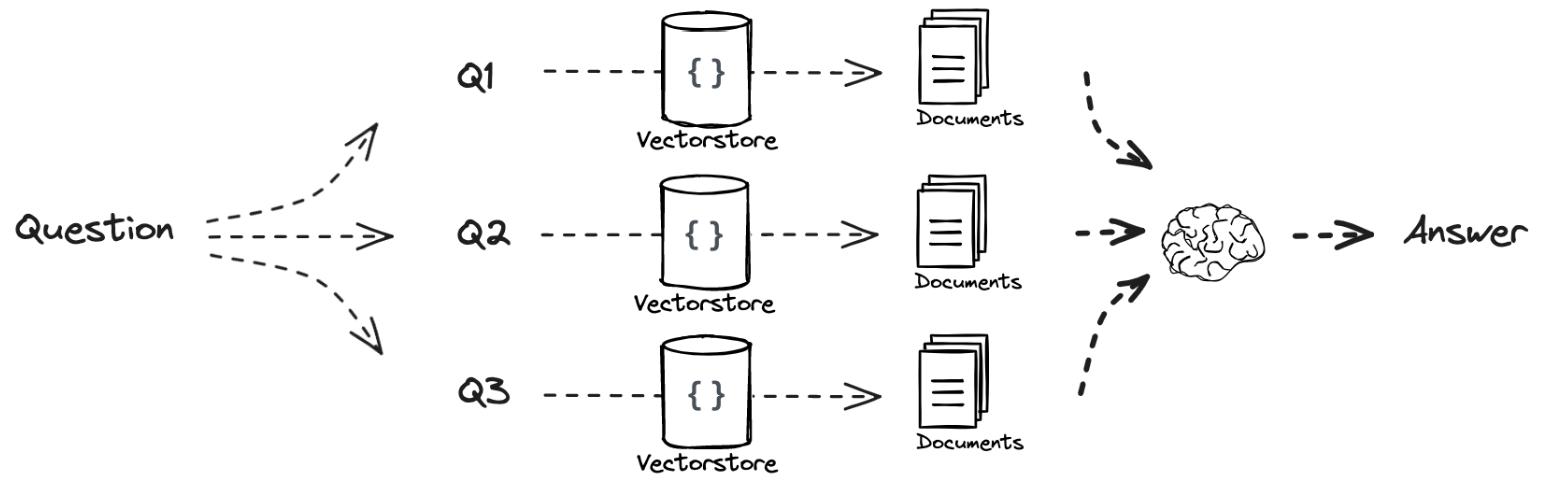

Docs:
* https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever
图片来源:
* 【🔥 从零开始学习 RAG｜2️⃣ 优化原始提问】 https://www.bilibili.com/video/BV1QE421L7qe/?share_source=copy_web&vd_source=f65342ebbf0b68f07ba0fc6772b947f7
* Bilibili @沧海九粟

## 1.1 环境导入

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['http_proxy'] = os.getenv("http_proxy")
os.environ['https_proxy'] = os.getenv("https_proxy")

os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

os.environ["DASHSCOPE_API_KEY"] = os.getenv("DASHSCOPE_API_KEY")

## 1.2 加载数据

In [2]:
from langchain.document_loaders import TextLoader, DirectoryLoader

home_path = os.getcwd()
data_path = os.path.join(home_path, 'data')
text_loader_kwargs ={'autodetect_encoding': True}
loader = DirectoryLoader(data_path, glob="**/*.txt", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs, show_progress=True)
docs = loader.load()

100%|██████████| 8/8 [00:00<00:00, 24.88it/s]


## 1.3 建立向量数据库

In [3]:
from langchain_community.embeddings import DashScopeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(docs)
db = Chroma.from_documents(documents, DashScopeEmbeddings())

## 1.4 建立第一条链——问题ReWrite

In [7]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatTongyi

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

# from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatTongyi(model='qwen-turbo')
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

## 1.5 建立第二条链——检索

In [8]:
from langchain.load import dumps, loads

retriever = db.as_retriever()

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
retrieval_chain = generate_queries | retriever.map() | get_unique_union

## 1.6 建立第三条链——问答

In [9]:
from operator import itemgetter
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# llm = ChatOpenAI(temperature=0)
llm = ChatTongyi(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

question = "What is task decomposition for LLM agents?"
final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down complex tasks into simpler sub-tasks, which are then handled by different modules or components within the system. According to the provided documents, this approach mimics user behaviors on the web by dividing tasks into manageable parts that are executed by specialized modules. However, this static method has limitations as it struggles to cope with the dynamic and complex nature of user interactions on the web and may not adapt well to real-world environments.\n\nAn alternative approach allows LLMs to explore and interact with the environment freely, enabling them to make decisions based on feedback from the environment or humans, thereby providing more flexibility and a behavior pattern that resembles human actions. This adaptive approach contrasts with the static task decomposition method by offering greater autonomy and responsiveness to varying conditions.'